In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
import pandas as pd
from theano import tensor as T

In [3]:
df = pd.read_csv('../data/mastectomy.csv')
df = df.assign(event = np.array(df['event'].values == True).astype(int))
df = df.assign(metastized = np.array(df['metastized'].values == 'yes').astype(int))
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [29]:
df.loc[df['metastized']==0].sort_values(by=['time','metastized'])

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0
5,101,0,0
6,148,1,0
7,181,1,0
8,198,0,0
9,208,0,0


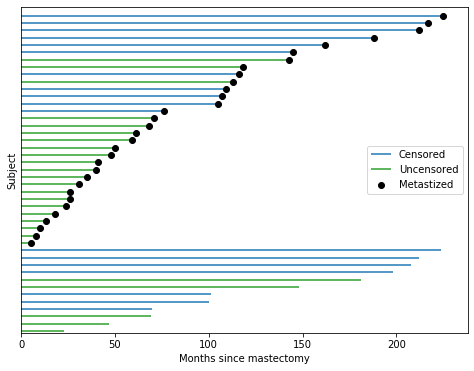

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].time,
          color=blue, label='Censored')

ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].time,
          color=red, label='Uncensored')

ax.scatter(df[df.metastized.values == 1].time, patients[df.metastized.values == 1],
           color='k', zorder=10, label='Metastized')

ax.set_xlim(left=0)
ax.set_xlabel('Months since mastectomy')
ax.set_yticks([])
ax.set_ylabel('Subject')

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='center right');

In [6]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

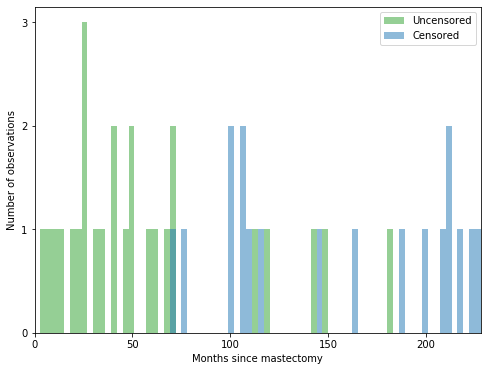

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(df[df.event == 1].time.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored');
ax.hist(df[df.event == 0].time.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored');

ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Months since mastectomy');

ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');

ax.legend();

In [8]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event

In [9]:
exposure = np.greater_equal.outer(df.time.values, interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

In [10]:
SEED = 644567 # from random.org

In [22]:
exposure

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 3, 3, 3]])

In [11]:
with pm.Model() as model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sigma=1000)

    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.metastized), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)

In [12]:
n_samples = 1000
n_tune = 1000

In [13]:
with model:
    trace = pm.sample(n_samples, tune=n_tune, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, lambda0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
There were 998 divergences after tuning. Increase `target_accept` or reparameterize.
There were 995 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6375765201340926, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
np.exp(trace['beta'].mean())

1.4808053766074636

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


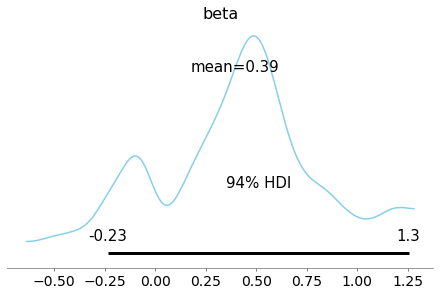

In [15]:
pm.plot_posterior(trace, var_names=['beta'], color='#87ceeb');

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


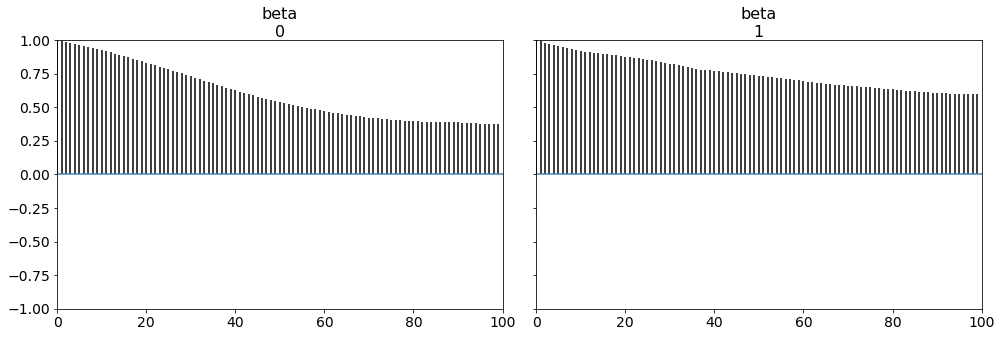

In [16]:
pm.autocorrplot(trace, var_names=['beta']);

In [17]:
base_hazard = trace['lambda0']
met_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

In [18]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [19]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

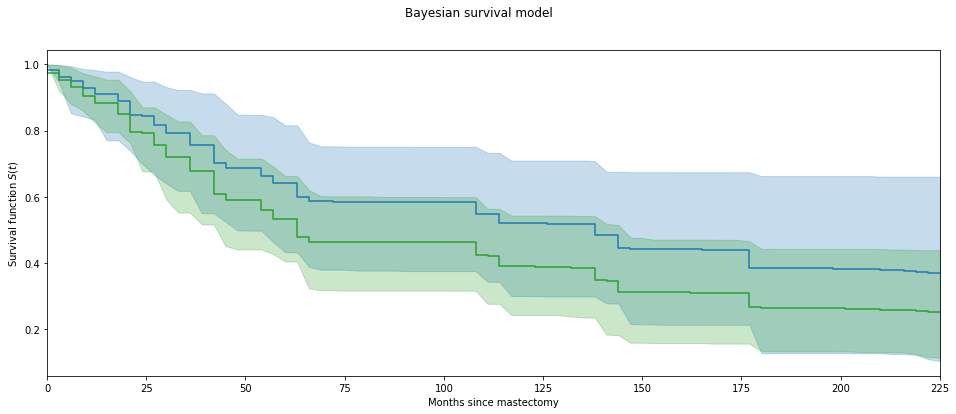

In [26]:
fig, (surv_ax) = plt.subplots(ncols=1, sharex=True, sharey=False, figsize=(16, 6))

#plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard, hazard_ax, color=blue, label='Had not metastized')
#plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard, hazard_ax, color=red, label='Metastized')

#hazard_ax.set_xlim(0, df.time.max());
#hazard_ax.set_xlabel('Months since mastectomy');
#hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');
#hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], base_hazard, survival, surv_ax, color=blue)

plot_with_hpd(interval_bounds[:-1], met_hazard, survival, surv_ax, color=red)

surv_ax.set_xlim(0, df.time.max());
surv_ax.set_xlabel('Months since mastectomy');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');